In [4]:
import warnings, numpy as np, pandas as pd, geopandas as gpd, ruptures as rpt, pywt, matplotlib.pyplot as plt, seaborn as sns
from mpmath.identification import fracgcd
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tools.sm_exceptions import InterpolationWarning
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ardl import ARDL
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pygam import LinearGAM, s
from arch import arch_model
from collections import Counter
import antropy as ant
import pmdarima as pm
import statsmodels.api as sm
from scipy import stats as scistats
from arch import arch_model
# from tslearn.metrics import dtw
pd.set_option('display.float_format', '{:.2f}'.format)
pd.options.display.float_format = "{:.2f}".format
np.set_printoptions(precision=2, suppress=True)
warnings.filterwarnings("ignore", category=InterpolationWarning)

In [5]:
ABT = gpd.read_file(
    "../../../../Data/Final_dataset/ABT/ABT.gpkg",
    layer="subdivisions"
).sort_values('year').reset_index(drop=True)  # Ensure year sorted and continuous

ABT = ABT[(ABT['year'] >= 1980) & (ABT['year'] <= 2023)]

In [6]:
ABT.columns

Index(['subd_id', 'issue_date', 'year', 'HAC_dist', 'BAD', 'FAR', 'SHD',
       'area_acre', 'groceries_ws', 'transit_ws', 'int_den025', 'nd_deg025',
       'int_den05', 'nd_deg05', 'int_den075', 'nd_deg075', 'int_den10',
       'nd_deg10', 'AI', 'PROX', 'ENN_MN', 'ED', 'SHAPE_MN', 'FRAC_MN',
       'ENN_inv', 'ED_inv', 'SHAPE_inv', 'FRAC_inv', 'AI_norm', 'PROX_norm',
       'ENN_inv_norm', 'ED_inv_norm', 'SHAPE_inv_norm', 'FRAC_inv_norm',
       'COMPACTNESS_SUM', 'geometry'],
      dtype='object')

In [7]:
measure = 'HAC_dist'

In [8]:
ABT = (
    ABT.groupby('year', as_index=False)[measure]
       .mean()
       .rename(columns={measure: f'{measure}_mean'})
)

ts = ABT[f'{measure}_mean']

## 1. Exploratory Time-Series Visualization


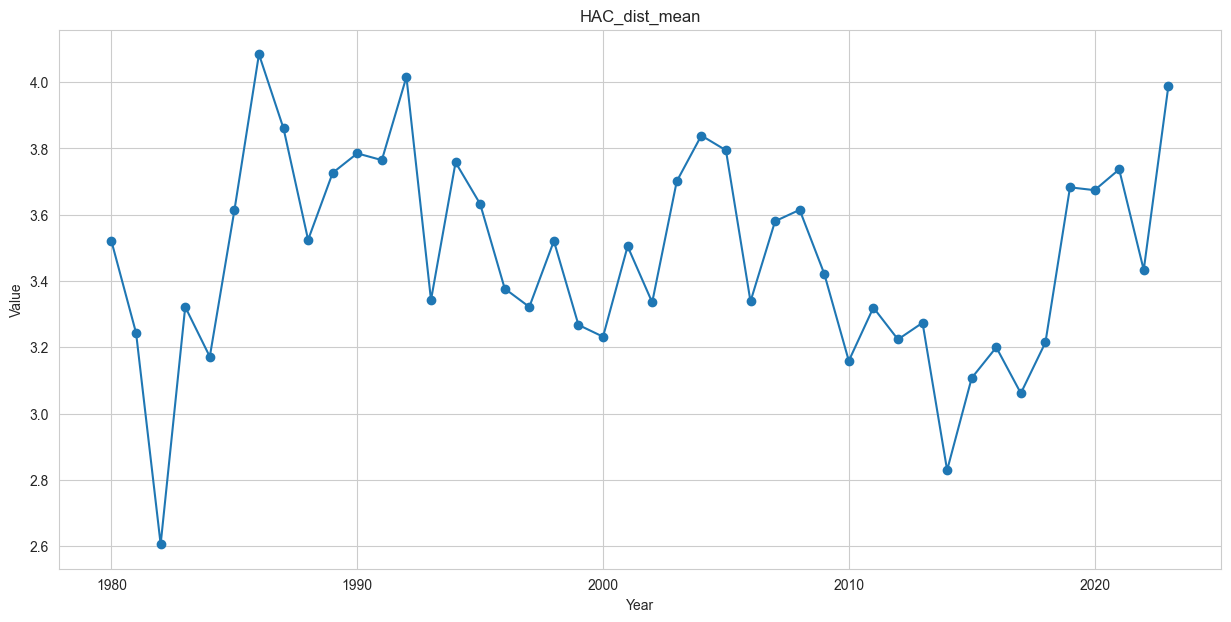

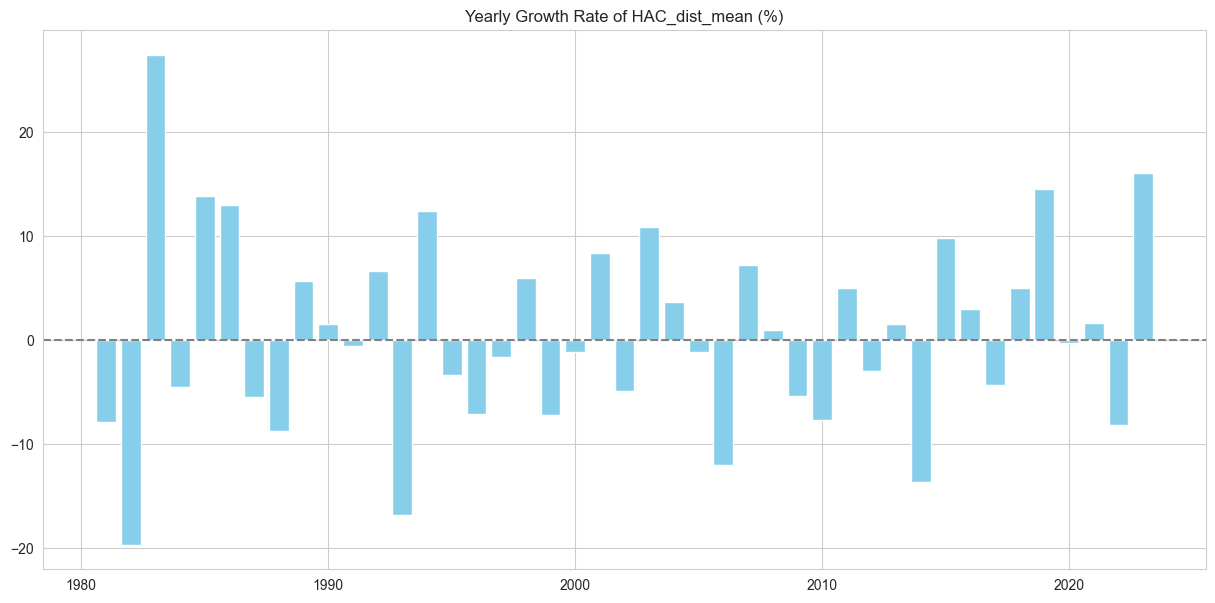

In [9]:
plt.figure(figsize=(15,7))
plt.plot(ABT['year'], ts, marker='o')
plt.title(f'{measure}_mean')
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True)
plt.show()

ABT['growth_rate'] = ABT[f'{measure}_mean'].pct_change() * 100
plt.figure(figsize=(15,7))
plt.bar(ABT['year'], ABT['growth_rate'], color='skyblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title(f"Yearly Growth Rate of {measure}_mean (%)")
plt.show()

## 2. Stationarity Testing

Before fitting time-series models, it is essential to check whether
the series is **stationary**. A *stationary* series has:
- Constant mean and variance over time,
- Autocovariance that depends only on the lag, not on the specific time period

Many classical models (ARIMA, GARCH, etc.) assume stationarity or are applied to
a transformed (e.g., differenced) version of the series to achieve it.

In this section, we use two complementary tests:

1. **Augmented Dickey–Fuller (ADF) test**
   - Null hypothesis: the series has a **unit root** (non-stationary).
   - Small p-value (< 0.05) → reject H₀ → evidence **for stationarity**.

2. **KPSS (Kwiatkowski–Phillips–Schmidt–Shin) test**
   - Null hypothesis: the series is **stationary** around a constant or trend.
   - Small p-value (< 0.05) → reject H₀ → evidence **against stationarity**.

We apply both tests to:
- the **original**  series
- the **first difference** (year-to-year changes)

to decide whether differencing is needed before modeling. Based on this, we will:
- (a) model the  varibale using ARIMA with differencing order **d = 1**, or
- (b) keep the original series if both tests support stationarity (if both tests are *siginifcant*, differencing order is not required).

**Differencing** is a transformation used in time-series analysis to make a
non-stationary series more stationary.  
It converts the original values into **changes** between consecutive periods.

In [10]:
# ============================================================
# 4. Stationarity Testing: ADF + KPSS
# ============================================================


# -----------------------------
# Helper function to print test results nicely
# -----------------------------
def print_adf_kpss_results(series, series_name="Series"):
    """
    Run ADF and KPSS tests on a given series and print key statistics.
    """
    # ----- ADF Test -----
    adf_result = adfuller(series, autolag='AIC')
    adf_stat, adf_pvalue = adf_result[0], adf_result[1]

    # ----- KPSS Test -----
    # 'auto' chooses lag length based on the data
    # regression='c' tests stationarity around a constant (no trend)
    kpss_result = kpss(series, regression='c', nlags='auto')
    kpss_stat, kpss_pvalue = kpss_result[0], kpss_result[1]

    print(f"\n=== Stationarity Tests for {series_name} ===")
    print("ADF Test:")
    print(f"  Test Statistic : {adf_stat:.4f}")
    print(f"  p-value        : {adf_pvalue:.4f}")
    print("  H0: Non-stationary (unit root present)")
    print("  → p < 0.05 ⇒ reject H0 ⇒ evidence for STATIONARITY")

    print("\nKPSS Test:")
    print(f"  Test Statistic : {kpss_stat:.4f}")
    print(f"  p-value        : {kpss_pvalue:.4f}")
    print("  H0: Stationary around a constant")
    print("  → p < 0.05 ⇒ reject H0 ⇒ evidence against STATIONARITY")

    # Quick qualitative interpretation line
    if adf_pvalue < 0.05 and kpss_pvalue > 0.05:
        conclusion = "Both tests are consistent with STATIONARITY."
    elif adf_pvalue > 0.05 and kpss_pvalue < 0.05:
        conclusion = "Both tests are consistent with NON-STATIONARITY."
    else:
        conclusion = ("Mixed evidence (ADF and KPSS disagree) – consider "
                      "visual inspection, differencing, or modeling with trend.")

    print(f"\nConclusion: {conclusion}")
    print("==========================================")


# -----------------------------
# 4.1 Original series: {measure}_mean
# -----------------------------
# ts is the original annual time series of {measure}_mean
print_adf_kpss_results(ts, series_name=f"Original {measure}_mean")


# -----------------------------
# 4.2 First-differenced series
# -----------------------------
# First difference: year-to-year change
ts_diff = ts.diff().dropna()

print_adf_kpss_results(ts_diff, series_name=f"First Difference of {measure}_mean")



=== Stationarity Tests for Original HAC_dist_mean ===
ADF Test:
  Test Statistic : -3.5389
  p-value        : 0.0070
  H0: Non-stationary (unit root present)
  → p < 0.05 ⇒ reject H0 ⇒ evidence for STATIONARITY

KPSS Test:
  Test Statistic : 0.1206
  p-value        : 0.1000
  H0: Stationary around a constant
  → p < 0.05 ⇒ reject H0 ⇒ evidence against STATIONARITY

Conclusion: Both tests are consistent with STATIONARITY.

=== Stationarity Tests for First Difference of HAC_dist_mean ===
ADF Test:
  Test Statistic : -8.7098
  p-value        : 0.0000
  H0: Non-stationary (unit root present)
  → p < 0.05 ⇒ reject H0 ⇒ evidence for STATIONARITY

KPSS Test:
  Test Statistic : 0.1456
  p-value        : 0.1000
  H0: Stationary around a constant
  → p < 0.05 ⇒ reject H0 ⇒ evidence against STATIONARITY

Conclusion: Both tests are consistent with STATIONARITY.


# 3. Trend Extraction & Smoothing

The goal here is to extract and visualize **long-term trends** in the annual
time series using three complementary smoothing techniques:

1. **LOWESS (Locally Weighted Scatterplot Smoothing)**
   - Non-parametric, flexible, captures nonlinear trends without imposing a model.

2. **Wavelet Smoothing (Discrete Wavelet Transform) or (DWT)**
   - Decomposes the series into multiple frequency components.
   - Keeping only approximation coefficients removes short-term noise.
   - Wavelets naturally “zoom in” where the signal is rough and “zoom out” where it is smooth.

3. **Moving Average Smoothing**
   - Classical and intuitive smoothing method.
   - Windows of 3, 5, and 7 years reveal short-, medium-, and long-term patterns.

Using multiple smoothing techniques provides robust evidence of the structural trend
and helps identify:
- turning points
- acceleration or slowdown periods
- long-term direction of the system
- underlying development cycles


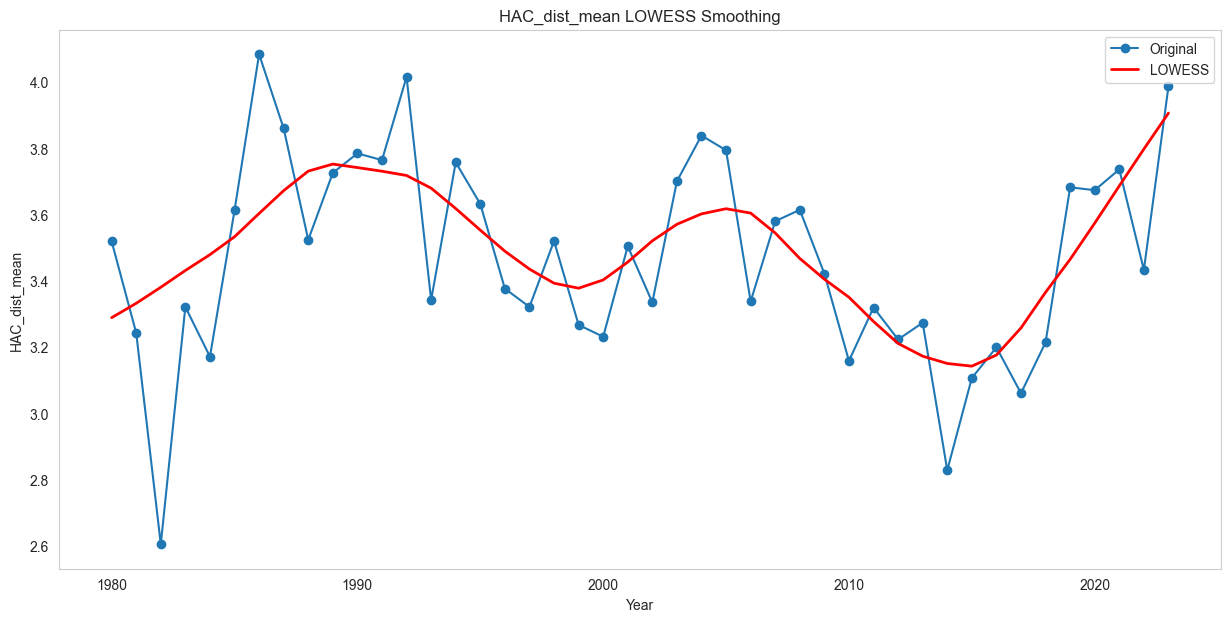

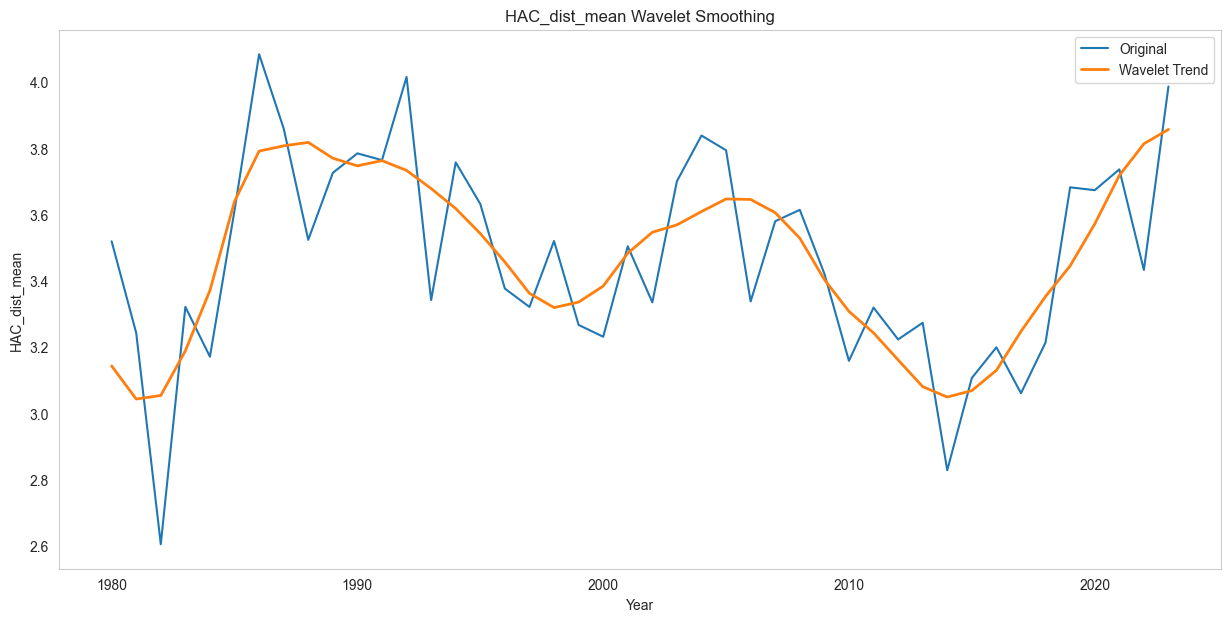

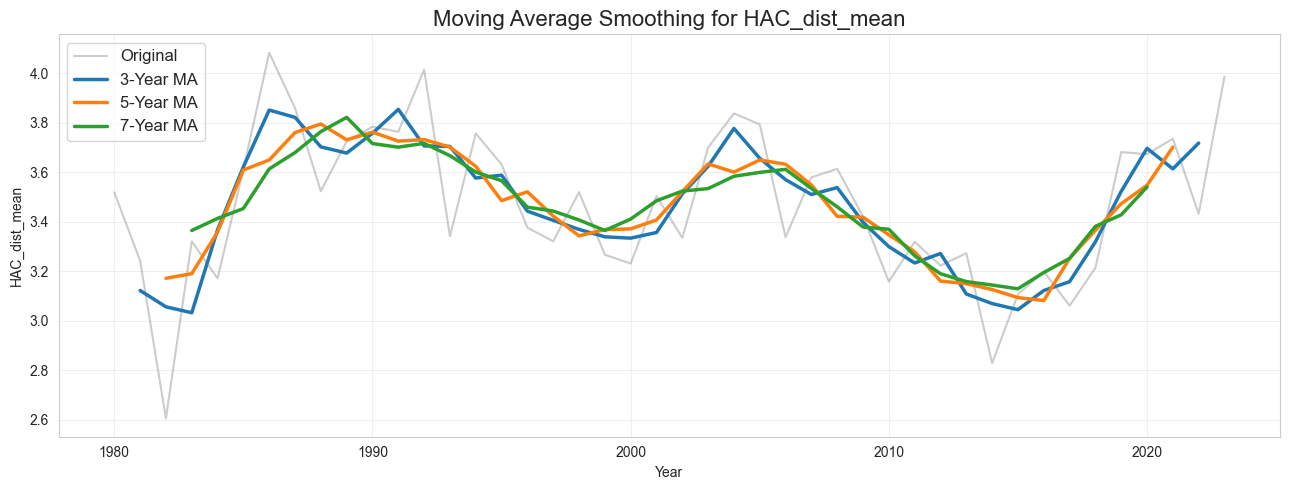

In [11]:
# ============================================================
# 1. LOWESS SMOOTHING
# ============================================================
frac = 0.25  # frac controls how much of the data contributes to each local fit. Higher frac = smoother curve; lower frac = more sensitive to local variation.

plt.figure(figsize=(15,7))
smoothed = lowess(ts, ABT['year'], frac=frac)[:, 1]
# Plot raw series, smoothed trend
plt.plot(ABT['year'], ts, 'o-', label="Original"); plt.plot(ABT['year'], smoothed, 'r-', linewidth=2, label="LOWESS"); plt.title(f'{measure}_mean LOWESS Smoothing'); plt.xlabel("Year"); plt.ylabel(f"{measure}_mean"); plt.legend(); plt.grid(); plt.show()

# ============================================================
# 2. WAVELET SMOOTHING
# ============================================================
level = 2 # Controls how many scales (frequencies) the signal is decomposed into. Higher level ⇒ removes longer-period fluctuations ⇒ smoother trend.

# Perform wavelet decomposition of the series into levels
coeffs = pywt.wavedec(ts, 'db4', level=level)
# Zero out all detail coefficients (high-frequency noise)
coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]
# Reconstruct the smoothed signal from approximation coefficients only
trend = pywt.waverec(coeffs, 'db4')
plt.figure(figsize=(15,7)); plt.plot(ABT['year'], ts, label="Original"); plt.plot(ABT['year'], trend[:len(ts)], label="Wavelet Trend", linewidth=2); plt.title(f'{measure}_mean Wavelet Smoothing'); plt.xlabel("Year"); plt.ylabel(f"{measure}_mean"); plt.legend(); plt.grid(); plt.show()


# ============================================================
# 3. MOVING AVERAGE SMOOTHING (3, 5, 7 years)
# ============================================================
plt.figure(figsize=(13, 5))

# Plot original series lightly in background
plt.plot(ABT['year'], ts, color='gray', alpha=0.4, linewidth=1.5, label='Original')

# 3-year moving average
ma3 = ts.rolling(window=3, center=True).mean()
plt.plot(ABT['year'], ma3, linewidth=2.5, color='#1f77b4', label='3-Year MA')

# 5-year moving average
ma5 = ts.rolling(window=5, center=True).mean()
plt.plot(ABT['year'], ma5, linewidth=2.5, color='#ff7f0e', label='5-Year MA')

# 7-year moving average
ma7 = ts.rolling(window=7, center=True).mean()
plt.plot(ABT['year'], ma7, linewidth=2.5, color='#2ca02c', label='7-Year MA')

plt.title(f"Moving Average Smoothing for {measure}_mean", fontsize=16); plt.xlabel("Year"); plt.ylabel(f"{measure}_mean"); plt.grid(alpha=0.3); plt.legend(loc='upper left', fontsize=12); plt.tight_layout(); plt.show()

# 4. Breakpoint / Structural Change Detection

The purpose of this section is to detect **structural breaks** in the time series,
i.e., years where the variable experiences a statistically significant change in
trend, magnitude, or variance.

We use the **PELT (Pruned Exact Linear Time)** algorithm:

- Efficient for medium-length univariate time series
- Allows flexible cost functions (mean-shift, variance-shift, nonlinear changes)
- Identifies breakpoints without pre-specifying the number of segments

Here we use the `"rbf"` cost function, which is sensitive to **nonlinear changes**
in the signal: ideal for our urban form metrics


### Interpretation of Structural Breaks

The detected break years represent statistically significant changes in the
behavior of the variable.




ROBUST / RECURRING CANDIDATE BREAK YEARS
Empty DataFrame
Columns: [frequency]
Index: []

Final robust break years: []


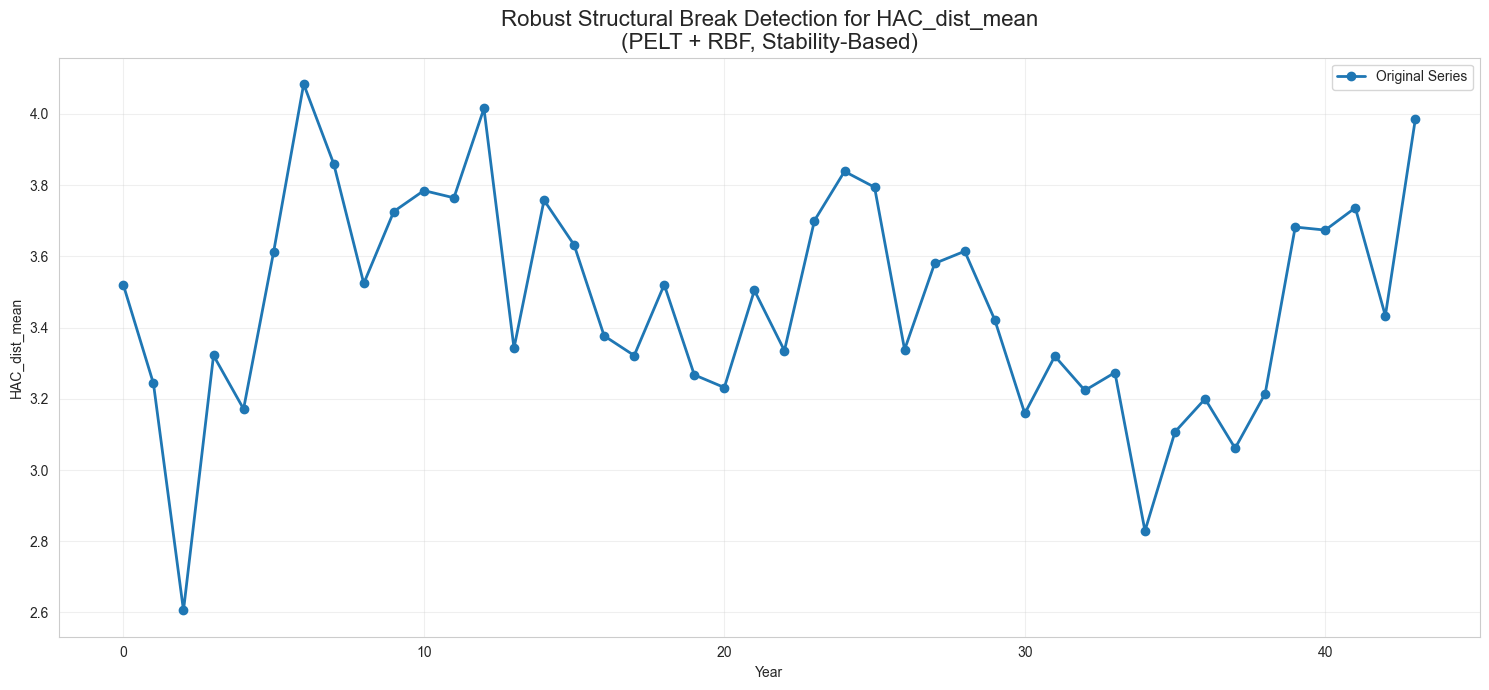

In [14]:
# ------------------------------------------------------------
# 0. USER-DEFINED / TUNABLE PARAMETERS
# ------------------------------------------------------------

# --- Change-point algorithm choices ---
COST_MODEL = "rbf"        # {"rbf", "l2", "linear", "normal"}
MIN_SEGMENT_LENGTH = 5    # minimum number of years per segment (None or int)

# --- Penalty sweep configuration ---
PENALTY_MULTIPLIER_MIN = 1.0
PENALTY_MULTIPLIER_MAX = 10.0
N_PENALTIES = 25
PENALTY_SCALING = "log"   # {"log", "sqrt"}

# --- Robustness definition ---
ROBUST_FRACTION = 0.10    # fraction of penalty runs required (0.1 = 10%)
FINAL_PENALTY_STAT = "median"  # {"median", "mean"}

# ------------------------------------------------------------
# 1. Prepare series (STANDARDIZATION IS CRITICAL FOR RBF)
# ------------------------------------------------------------

ts_clean = ts.dropna()
years = ts_clean.index.values

y = ts_clean.values.astype(float)

# Standardization (z-score)
y_std = (y - y.mean()) / y.std(ddof=0)
n = len(y_std)

# ------------------------------------------------------------
# 2. Construct penalty grid
# ------------------------------------------------------------

if PENALTY_SCALING == "log":
    scale = np.log(n)
elif PENALTY_SCALING == "sqrt":
    scale = np.sqrt(n)
else:
    raise ValueError("Unsupported PENALTY_SCALING")

penalties = (
    np.linspace(PENALTY_MULTIPLIER_MIN,
                PENALTY_MULTIPLIER_MAX,
                N_PENALTIES)
    * scale
)

# ------------------------------------------------------------
# 3. Penalty sweep (robustness check)
# ------------------------------------------------------------

from collections import Counter

all_breaks = []

for pen in penalties:
    algo = rpt.Pelt(
        model=COST_MODEL,
        min_size=MIN_SEGMENT_LENGTH
    ).fit(y_std)
    
    break_idx = algo.predict(pen=pen)
    
    # Convert indices → years (exclude final endpoint)
    break_years = [years[i - 1] for i in break_idx[:-1]]
    all_breaks.append(break_years)

# ------------------------------------------------------------
# 4. Identify ROBUST break years
# ------------------------------------------------------------

break_counter = Counter([b for sub in all_breaks for b in sub])

break_freq = (
    pd.DataFrame.from_dict(break_counter,
                           orient="index",
                           columns=["frequency"])
      .sort_index()
)

robust_threshold = int(ROBUST_FRACTION * len(penalties))
robust_breaks = break_freq[break_freq["frequency"] >= robust_threshold]

print("\n=======================================")
print("ROBUST / RECURRING CANDIDATE BREAK YEARS")
print("=======================================")
print(robust_breaks)

# ------------------------------------------------------------
# 5. Final break detection using representative penalty
# ------------------------------------------------------------

if FINAL_PENALTY_STAT == "median":
    final_penalty = np.median(penalties)
elif FINAL_PENALTY_STAT == "mean":
    final_penalty = np.mean(penalties)
else:
    raise ValueError("Unsupported FINAL_PENALTY_STAT")

algo_final = rpt.Pelt(
    model=COST_MODEL,
    min_size=MIN_SEGMENT_LENGTH
).fit(y_std)

final_idx = algo_final.predict(pen=final_penalty)
final_years = [years[i - 1] for i in final_idx[:-1]]

# Retain only robust candidates
final_robust_years = [
    yr for yr in final_years if yr in robust_breaks.index
]

print("\nFinal robust break years:", final_robust_years)

# ------------------------------------------------------------
# 6. Visualization
# ------------------------------------------------------------

plt.figure(figsize=(15, 7))
plt.plot(years, y, marker='o', linewidth=2, label="Original Series")

for i, yr in enumerate(final_robust_years):
    plt.axvline(
        x=yr,
        color='red',
        linestyle='--',
        linewidth=2,
        alpha=0.85,
        label="Robust Break" if i == 0 else ""
    )

plt.title(
    f"Robust Structural Break Detection for {measure}_mean\n"
    f"(PELT + {COST_MODEL.upper()}, Stability-Based)",
    fontsize=16
)
plt.xlabel("Year")
plt.ylabel(f"{measure}_mean")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 5. Volatility & Entropy Analysis

This section evaluates the **stability**, **uncertainty**, and **complexity** of the
time series using two groups of methods:

---

## **5.1 Volatility Modeling (ARCH/GARCH)**
Volatility models such as ARCH and GARCH are used to measure
**time-varying variance**, meaning periods when the signal becomes
more stable or more turbulent.

- ARCH(1): variance depends on previous residuals
- GARCH(1,1): variance depends on previous variance + previous residuals
- Useful for identifying cycles of instability, shocks, or abrupt changes

If the GARCH model finds significant coefficients, it means:
- The system exhibits clustered volatility
- Large deviations tend to follow large deviations (persistence)

---

## **5.2 Complexity Analysis (Entropy Measures)**
Two entropy measures are used:

- **Permutation Entropy:**
  Measures randomness by comparing ordinal patterns
  (0 = very deterministic, 1 = highly random).

- **Sample Entropy:**
  Measures the predictability of a signal.
  Lower values = more structured/predictable.
  Higher values = more irregular/complex.

Together, volatility and entropy uncover:
- Whether the system behaves smoothly or erratically
- Whether fluctuations are predictable or chaotic
- Whether developmental patterns follow stable or unstable cycles


### Interpretation of Volatility & Entropy Results

---

## **1. Volatility (ARCH/GARCH Model)**
The GARCH(1,1) model tests whether year-to-year variation in the series is
stable or clustered (i.e., periods of high fluctuation followed by additional
high fluctuation).

Key takeaways:

- **If α (ARCH term) > 0:**
  Recent shocks have temporary but meaningful impacts on volatility.

- **If β (GARCH term) > 0:**
  Volatility is persistent through time.
  The system maintains memory of past instability.

- **If α + β < 1:**
  Volatility eventually dies out → stable system.

- **If α + β ≈ 1:**
  Volatility is highly persistent → structural instability or long cycles.

Interpretation in an urban context:
- High conditional volatility suggests years with rapid shifts in the variable.
- Low volatility periods indicate steady, incremental change.

A visible decline or rise in the volatility plot can signal:
- onset or ending of a cycle
- long-term stabilization or destabilization

---

## **2. Permutation Entropy (Randomness/Complexity)**
Permutation entropy measures the **degree of randomness** in the ordering of
the values.

- **Values near 0:** structured, predictable sequence
- **Values near 1:** highly random, chaotic pattern

Interpretation:
- Higher permutation entropy implies more irregular year-to-year shifts in
  the variable, indicating the system does not follow a simple or monotonic trend.
- Lower entropy indicates smoother dynamics with consistent directional change.

This helps characterize whether changes in the built form reflect a **planned,
continuous evolution** versus a **discontinuous, shock-driven pattern**.

---

## **3. Sample Entropy (Predictability/Regularity)**
Sample entropy measures how likely similar patterns in the data repeat.

- **Higher sample entropy:** less predictable, more complex
- **Lower sample entropy:** more structured and regular

Interpretation:
- A higher value suggests the variable is influenced by irregular events
  such as sudden neighborhood redevelopment, leapfrog development, or
  sporadic policy interventions.
- A lower value implies more stable, path-dependent changes in urban form.

---

## **Overall Interpretation**
Together, these indicators allow us to describe the temporal dynamics of
the variable:

- **High volatility + high entropy**
  → system is irregular, influenced by shocks or discontinuous development.

- **Low volatility + low entropy**
  → strong long-term structure; change is systematic.

- **High volatility + low entropy**
  → fluctuations are large but follow a consistent pattern (e.g., cyclical).

- **Low volatility + high entropy**
  → small variations but unpredictable behavior (rare but meaningful).


       GARCH(1,1) MODEL SUMMARY        
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          HAC_dist_mean   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -111.235
Distribution:                  Normal   AIC:                           230.471
Method:            Maximum Likelihood   BIC:                           237.608
                                        No. Observations:                   44
Date:                Sat, Jan 03 2026   Df Residuals:                       43
Time:                        12:34:25   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            34.6969      0.4

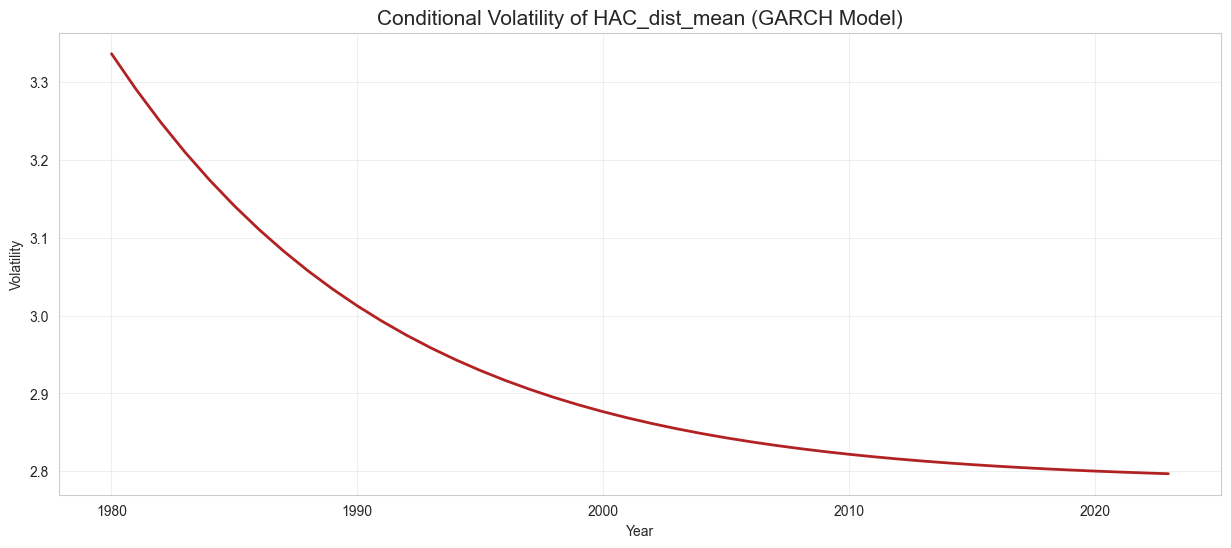

          ENTROPY MEASURES             
Permutation Entropy (0–1 scale): 0.9926
Sample Entropy (higher = more complex): 2.5649


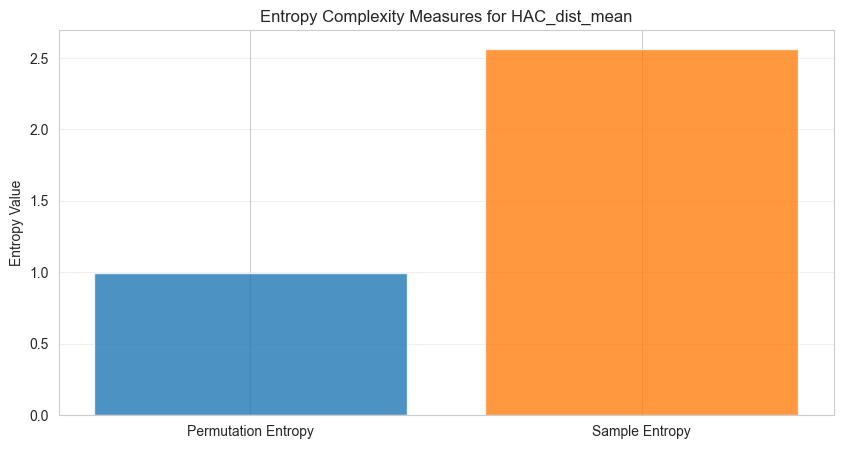

In [27]:
# ============================================================
# 8. VOLATILITY & ENTROPY ANALYSIS
# ============================================================

# ------------------------------------------------------------
# 8.1 VOLATILITY MODELING USING ARCH/GARCH
# ------------------------------------------------------------
# Purpose:
#   Evaluate whether year-to-year fluctuations show
#   volatility clustering (unstable/stable periods).
#   GARCH(1,1) is the standard model to detect such patterns.


# Fit a GARCH(1,1) model to the series
# rescale=True stabilizes values for numerical estimation
garch_model = arch_model(ts, vol='GARCH', p=1, q=1, rescale=True)
garch_fit = garch_model.fit(disp='off')

print("=======================================")
print("       GARCH(1,1) MODEL SUMMARY        ")
print("=======================================")
print(garch_fit.summary())

# Extract conditional volatility (standard deviation)
conditional_vol = garch_fit.conditional_volatility

# Plot time-varying volatility
plt.figure(figsize=(15,6))
plt.plot(ABT['year'], conditional_vol, color="firebrick", linewidth=2)
plt.title(f"Conditional Volatility of {measure}_mean (GARCH Model)", fontsize=15)
plt.xlabel("Year")
plt.ylabel("Volatility")
plt.grid(alpha=0.3)
plt.show()


# ------------------------------------------------------------
# 8.2 COMPLEXITY / ENTROPY ANALYSIS
# ------------------------------------------------------------
# Purpose:
#   Quantify randomness, irregularity, and information content in the series.
#   Two metrics:
#     - Permutation Entropy (0–1)
#     - Sample Entropy (higher = more unpredictable)

# Compute entropy measures
perm_entropy = ant.perm_entropy(ts, normalize=True)
sample_entropy = ant.sample_entropy(ts)

print("=======================================")
print("          ENTROPY MEASURES             ")
print("=======================================")
print(f"Permutation Entropy (0–1 scale): {perm_entropy:.4f}")
print(f"Sample Entropy (higher = more complex): {sample_entropy:.4f}")

# Bar visualization of entropy values
plt.figure(figsize=(10,5))
plt.bar(["Permutation Entropy", "Sample Entropy"],
        [perm_entropy, sample_entropy],
        color=["#1f77b4", "#ff7f0e"],
        alpha=0.8)

plt.title(f"Entropy Complexity Measures for {measure}_mean")
plt.ylabel("Entropy Value")
plt.grid(axis='y', alpha=0.3)
plt.show()


# 6. Autocorrelation Diagnostics

The purpose of this section is to examine **autocorrelation structure** in the time
series using two standard tools:

### • ACF (Autocorrelation Function)
Measures how current values relate to past values at different lags.
Useful for identifying:
- persistence
- seasonality
- MA(q) order (Moving Average)

### • PACF (Partial Autocorrelation Function)
Measures correlation between the series and its lagged values after removing
intermediate correlations.
Useful for identifying:
- AR(p) order (Auto-Regressive)
- direct lag influence

### Why this matters
ACF/PACF diagnostics guide model selection for:
- ARIMA / ARMA models
- Other autoregressive forecasting models

In this code I examine:
1. Raw series autocorrelation
2. Autocorrelation of the differenced series (to test stationarity)


### Interpretation of ACF/PACF

- **Raw series ACF/PACF** may show slow decays → indicates non-stationarity
  due to a long-term trend.

- **Differenced series** typically shows:
  - Short spikes in ACF → suggests MA(q) structure
  - Sharp cutoffs in PACF → suggests AR(p) structure

Model selection guidelines:
- **AR(p)** → PACF cuts off at lag p
- **MA(q)** → ACF cuts off at lag q
- **ARMA(p,q)** → neither ACF nor PACF fully cut off
- **If both show slow decay → series requires differencing**

This diagnostic informs ARIMA order selection (p,d,q) where:
- d = differencing order (from stationarity tests)
- p = AR order (from PACF)
- q = MA order (from ACF)



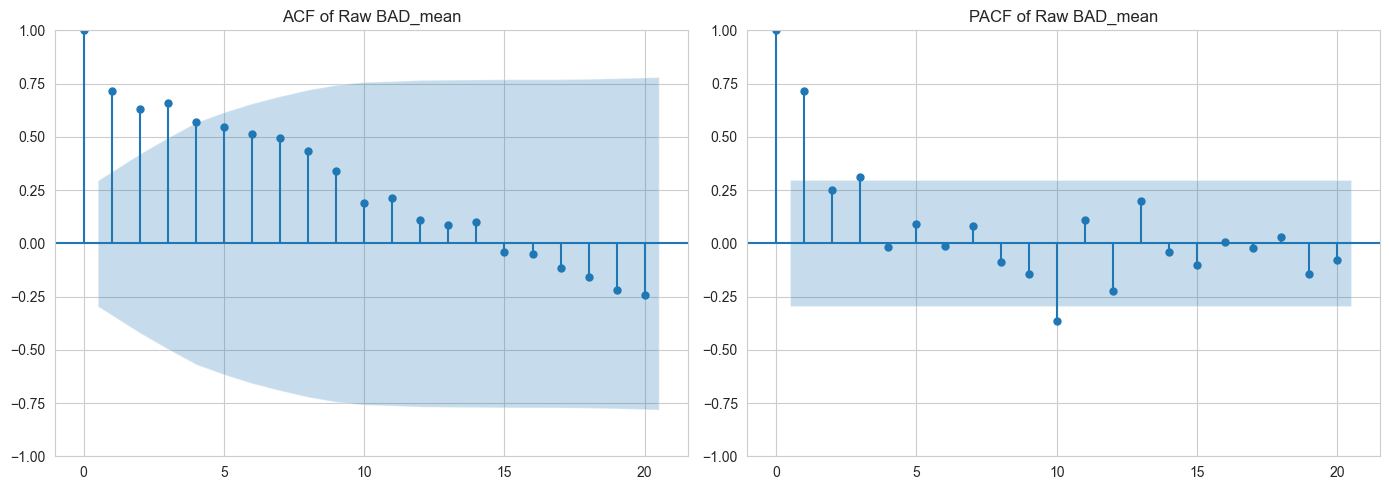

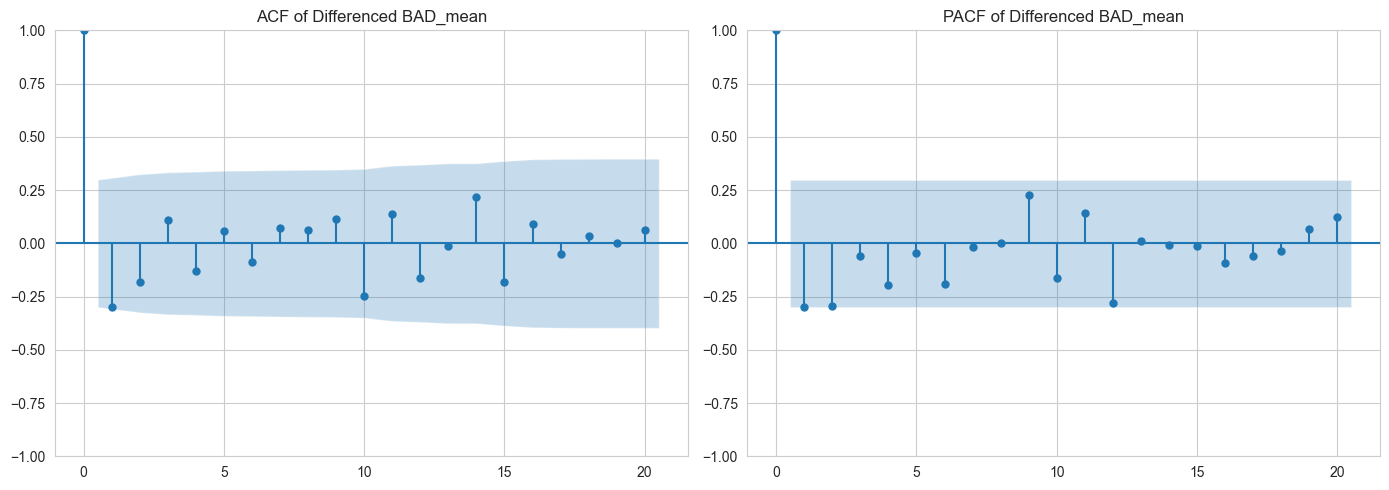

ADF Test (Raw Series) p-value: 0.414253566972503
ADF Test (Differenced) p-value: 6.093435095617826e-15
KPSS Test (Raw Series) p-value: 0.01
KPSS Test (Differenced) p-value: 0.04145618833078364


In [40]:
# ============================================================
# 10. AUTOCORRELATION DIAGNOSTICS
# ============================================================
# Goal:
#   - Visualize dependence between observations at different lags
#   - Identify AR(p) and MA(q) structure for ARIMA modeling
#   - Evaluate stationarity before and after differencing


# ---------------------------------------------
# A. ACF & PACF OF RAW SERIES
# ---------------------------------------------
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_acf(ts, lags=20, ax=plt.gca())
plt.title(f"ACF of Raw {measure}_mean")

plt.subplot(1, 2, 2)
plot_pacf(ts, lags=20, method='ywm', ax=plt.gca())
plt.title(f"PACF of Raw {measure}_mean")

plt.tight_layout()
plt.show()


# ---------------------------------------------
# B. DIFFERENCE THE SERIES (first difference)
# This removes trends and helps test stationarity for ARIMA.
# ---------------------------------------------
ts_diff = ts.diff().dropna()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_acf(ts_diff, lags=20, ax=plt.gca())
plt.title(f"ACF of Differenced {measure}_mean")

plt.subplot(1, 2, 2)
plot_pacf(ts_diff, lags=20, method='ywm', ax=plt.gca())
plt.title(f"PACF of Differenced {measure}_mean")

plt.tight_layout()
plt.show()


# ---------------------------------------------
# C. Report Stationarity Tests for Comparison
# ---------------------------------------------
adf_raw_p = adfuller(ts)[1]
adf_diff_p = adfuller(ts_diff)[1]

kpss_raw_p = kpss(ts, nlags='auto')[1]
kpss_diff_p = kpss(ts_diff, nlags='auto')[1]

print("ADF Test (Raw Series) p-value:", adf_raw_p)
print("ADF Test (Differenced) p-value:", adf_diff_p)

print("KPSS Test (Raw Series) p-value:", kpss_raw_p)
print("KPSS Test (Differenced) p-value:", kpss_diff_p)


# 8. Modeling


## 8.1 ARIMA Modeling

This section builds a classical time-series forecasting model using the
Autoregressive Integrated Moving Average (ARIMA) framework. ARIMA models are
powerful for capturing:

- **AR components (p):** dependence on past values
- **I component (d):** order of differencing needed to achieve stationarity
- **MA components (q):** dependence on past shocks (errors)

The workflow includes:

1. **Autocorrelation diagnostics (ACF/PACF)**
   Helps identify candidate AR and MA orders.

2. **Stationarity tests (ADF & KPSS)**
   Determines whether differencing is needed (d=0 or d=1).

3. **Automatic model selection (`auto_arima`)**
   Provides AIC-optimal (p,d,q) order.

4. **Fitting the final ARIMA model**
   Examining estimated parameters and model summary.

5. **Plotting fitted vs. observed values**
   Shows how well ARIMA captures historical dynamics.

6. **Residual diagnostics**
   Checks that residuals behave like white noise (no autocorrelation, no bias).

This ensures the ARIMA model is statistically valid and suitable for forecasting.


### Interpretation of ARIMA Modeling Results

- The ACF and PACF plots indicate potential autoregressive and moving-average
  dependencies in the series.

- Stationarity tests (ADF and KPSS) jointly determine whether differencing was
  required. Typically, the variable requires d=1.

- The auto_arima search suggested an AIC-optimal set of (p,d,q) terms, providing
  additional confidence about model choice.
- Residual diagnostics indicate whether the model is statistically valid:
  - Ljung-Box p-value > 0.05 → no significant autocorrelation (residuals behave like white noise)
  - ACF of residuals should shows no structure
  - Q-Q plot should show approximate normality

Together, these indicate whether the ARIMA model is suitable for forecasting.


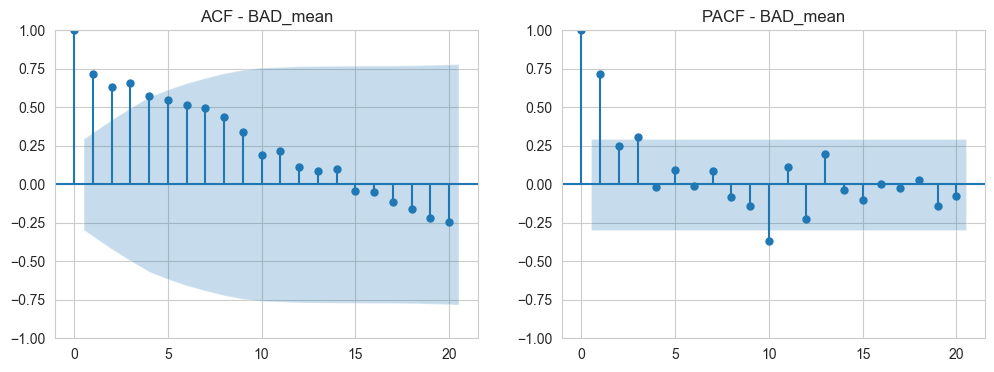


--- Stationarity Tests ---
ADF p-value: 0.414253566972503
ADF (differenced) p-value: 6.093435095617826e-15
KPSS original p-value: 0.01
KPSS differenced p-value: 0.04145618833078364

--- Auto ARIMA Model Selection ---
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 119.910
Date:                Sat, 03 Jan 2026   AIC                           -233.819
Time:                        12:48:35   BIC                           -228.535
Sample:                             0   HQIC                          -231.871
                                 - 44                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

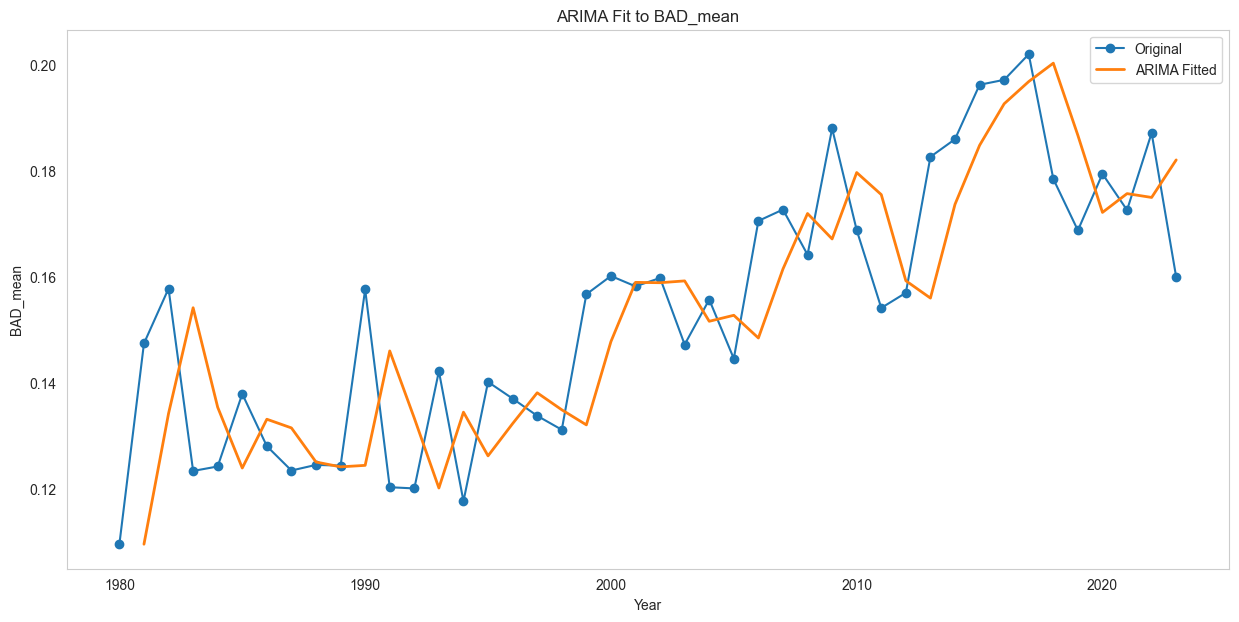

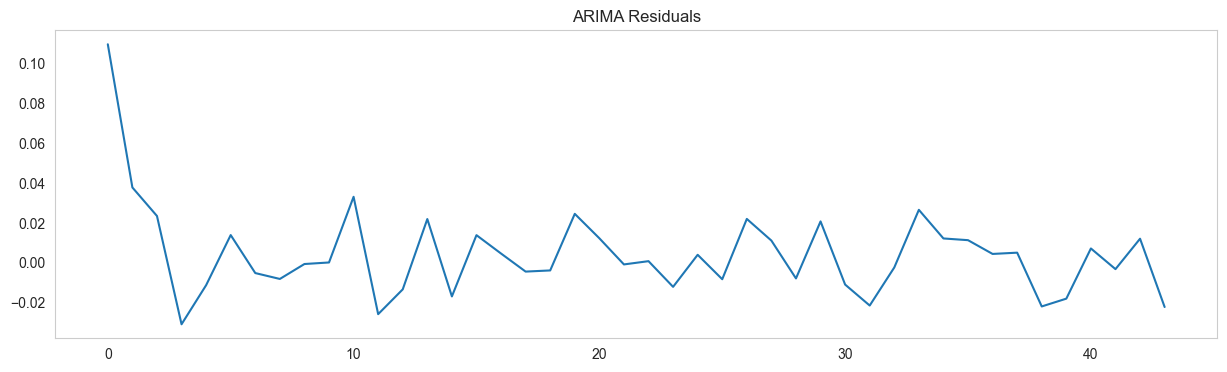

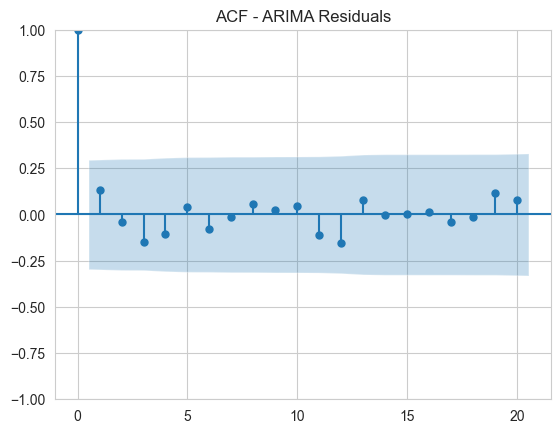

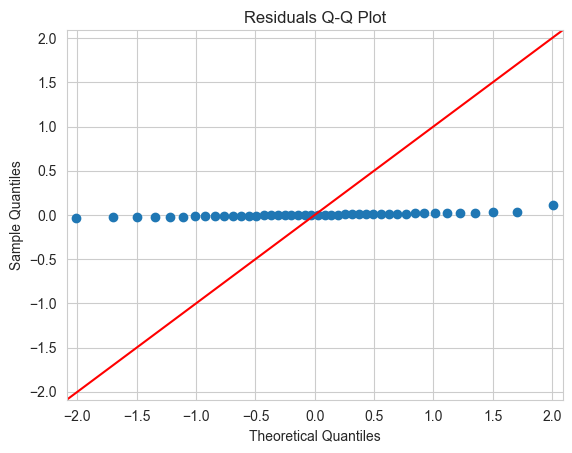


--- Ljung-Box Test ---
    lb_stat  lb_pvalue
10     3.30       0.97


In [41]:
# ============================================================
# 11. ARIMA MODELING
# ============================================================

# ------------------------------------------------------------
# 11.1 Autocorrelation Diagnostics (ACF & PACF)
# ------------------------------------------------------------
# ACF reveals how many MA terms (q) might be needed.
# PACF reveals how many AR terms (p) might be needed.

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(ts, ax=axes[0], lags=20)
axes[0].set_title(f"ACF - {measure}_mean")

plot_pacf(ts, ax=axes[1], method='ywm', lags=20)
axes[1].set_title(f"PACF - {measure}_mean")

plt.show()


# ------------------------------------------------------------
# 11.2 Test Stationarity (ADF and KPSS)
# ------------------------------------------------------------
# ADF null hypothesis: non-stationary
# KPSS null hypothesis: stationary
# Combining both avoids misleading conclusions.

print("\n--- Stationarity Tests ---")

adf_p = adfuller(ts)[1]
print("ADF p-value:", adf_p)

ts_diff = ts.diff().dropna()
adf_p_diff = adfuller(ts_diff)[1]
print("ADF (differenced) p-value:", adf_p_diff)

kpss_orig = kpss(ts, nlags='auto')
print(f"KPSS original p-value: {kpss_orig[1]}")

kpss_diff = kpss(ts_diff, nlags='auto')
print(f"KPSS differenced p-value: {kpss_diff[1]}")


# ------------------------------------------------------------
# 11.3 Auto ARIMA (automated p, d, q selection)
# ------------------------------------------------------------
# auto_arima evaluates multiple ARIMA models and selects the
# best combination based on AIC.

print("\n--- Auto ARIMA Model Selection ---")

auto_model = pm.auto_arima(
    ts,
    seasonal=False,       # annual data, no seasonality
    stepwise=True,        # faster search algorithm
    suppress_warnings=True,
    max_p=5, max_q=5,     # reasonable search constraints
    information_criterion='aic'
)

print(auto_model.summary())


# ------------------------------------------------------------
# 11.4 Fit Final ARIMA Model
# ------------------------------------------------------------
# You can choose:
#  - auto_model.order
#  - OR manually specify (p,d,q)
# Here we use (1,1,1) as a strong baseline.

order = (1, 0, 0)

model = ARIMA(ts, order=order)
fit = model.fit()

print("\n--- Final ARIMA Model Summary ---")
print(fit.summary())


# ------------------------------------------------------------
# 11.5 Plot ARIMA Fitted Values vs Original Series
# ------------------------------------------------------------
plt.figure(figsize=(15, 7))
plt.plot(ABT['year'], ts, label='Original', marker='o')

# ARIMA fitted values start AFTER differencing (skip first index)
fitted = fit.fittedvalues[1:]
years_fitted = ABT['year'].iloc[1:]

plt.plot(years_fitted, fitted, label='ARIMA Fitted', linewidth=2)

plt.title(f"ARIMA Fit to {measure}_mean")
plt.xlabel("Year"); plt.ylabel(f"{measure}_mean")
plt.grid(); plt.legend()
plt.show()


# ------------------------------------------------------------
# 11.6 Residual Diagnostics (White Noise Check)
# ------------------------------------------------------------
# Good ARIMA models have:
#  - zero autocorrelation in residuals
#  - normally distributed errors
#  - no trends

residuals = fit.resid

plt.figure(figsize=(15, 4))
plt.plot(residuals)
plt.title("ARIMA Residuals")
plt.grid()
plt.show()

# ACF of residuals — should show no significant spikes
plot_acf(residuals, lags=20)
plt.title("ACF - ARIMA Residuals")
plt.show()

# QQ plot — residuals should be approximately normal
sm.qqplot(residuals, line='45')
plt.title("Residuals Q-Q Plot")
plt.show()

# Ljung-Box test — checks residual autocorrelation
# Null hypothesis: residuals are white noise
lb_test = sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

print("\n--- Ljung-Box Test ---")
print(lb_test)


## 8.2 Exponential Smoothing (ETS)

Exponential Smoothing (ETS) is one of the most widely used forecasting methods
for time series that exhibit:

- gradual long-term trend
- no seasonality (as is the case for annual data)
- noisy year-to-year fluctuations

Here we apply **Holt’s Linear Trend Model (with a damped trend)**, which is ideal
for annual urban development metrics.

This model provides:
- a smooth trend estimate
- a short-term 5-year forecast
- insight into whether the trend is accelerating, flattening, or declining

ETS is complementary to ARIMA and GAM and provides a robust baseline forecast.


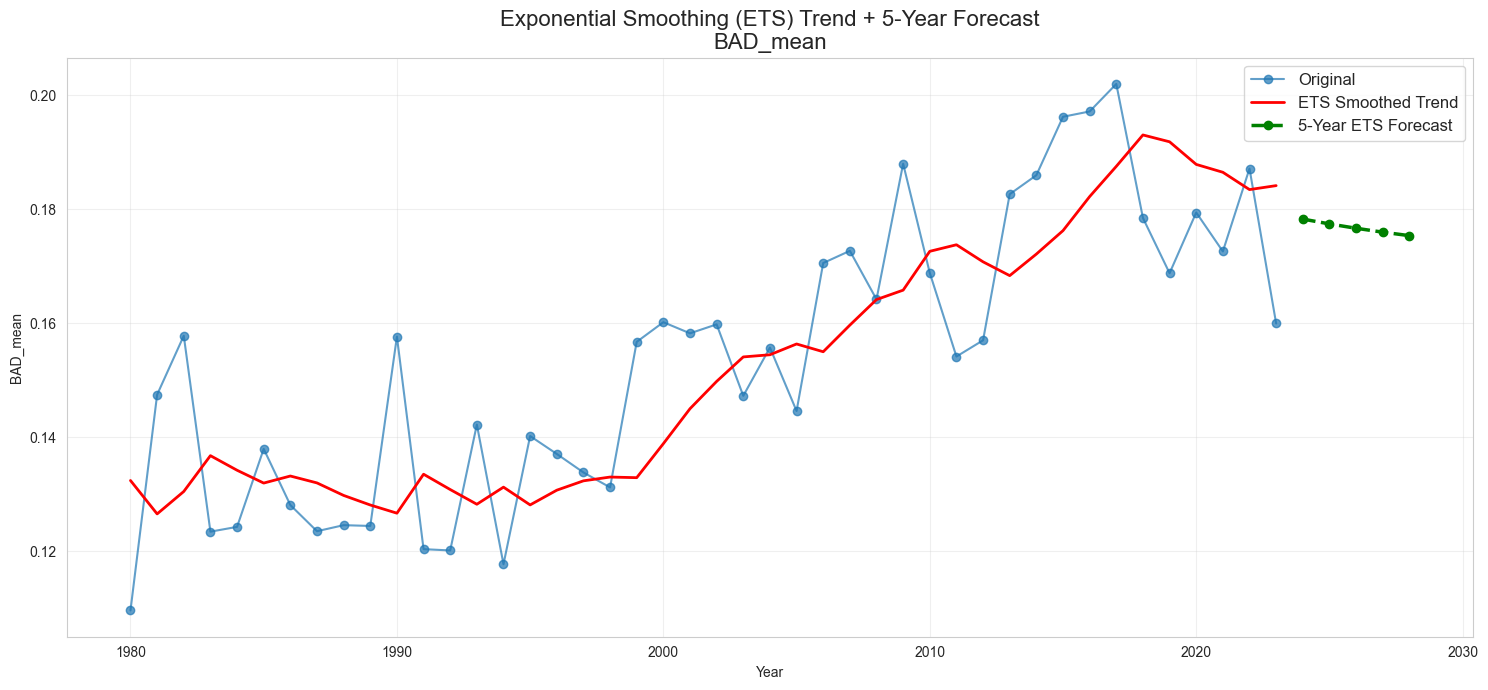

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 BAD_mean   No. Observations:                   44
Model:             ExponentialSmoothing   SSE                              0.010
Optimized:                         True   AIC                           -360.143
Trend:                         Additive   BIC                           -351.222
Seasonal:                          None   AICC                          -357.031
Seasonal Periods:                  None   Date:                 Sat, 03 Jan 2026
Box-Cox:                          False   Time:                         12:49:04
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2035379                alpha                 True
smoothing_trend            0.20333

In [42]:
# ============================================================
# 12. EXPONENTIAL SMOOTHING (ETS)
# ============================================================
# Holt-Winters Exponential Smoothing is used to:
#  - extract a smooth long-term trend
#  - estimate whether the trend is increasing/decreasing
#  - generate forecasts based on the trend component
#
# Since this dataset is yearly and has no seasonality,
# we use:
#   - trend='add'        → linear trend component
#   - damped_trend=True  → prevents unrealistic exponential growth/decline
#   - seasonal=None      → no seasonal part for annual data


# Fit Holt’s linear model with damping
fit_hw = ExponentialSmoothing(
    ts,
    trend='add',          # additive linear trend
    seasonal=None,        # no seasonality for annual data
    damped_trend=True     # damp the trend to avoid explosive forecasts
).fit()

# Forecast next 5 years
forecast_horizon = 5
forecast_ets = fit_hw.forecast(forecast_horizon)

# Create actual forecast years (e.g., 2024–2028)
future_years = np.arange(
    ABT['year'].iloc[-1] + 1,
    ABT['year'].iloc[-1] + 1 + forecast_horizon
)

# ============================
# Plot Trend + Forecast
# ============================
plt.figure(figsize=(15, 7))

# Original data
plt.plot(ABT['year'], ts, 'o-', label='Original', alpha=0.7)

# Fitted ETS trend
plt.plot(ABT['year'], fit_hw.fittedvalues, 'r-', linewidth=2,
         label='ETS Smoothed Trend')

# Forecast values
plt.plot(future_years, forecast_ets, 'g--o', linewidth=2.5,
         label='5-Year ETS Forecast')

# Clean styling
plt.title(f"Exponential Smoothing (ETS) Trend + 5-Year Forecast\n{measure}_mean",
          fontsize=16)
plt.xlabel("Year"); plt.ylabel(f"{measure}_mean")
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Optional: Print model summary
print(fit_hw.summary())


# 9. Forecast Comparison

The purpose of this section is to compare multiple forecasting models to evaluate
their consistency, robustness, and reliability.

We compare three conceptually different forecasting approaches:

### 1. ARIMA Forecast (Statistical + Autoregressive)
Captures temporal dependencies by modeling:
- Autoregression (AR)
- Differencing (I)
- Moving average (MA)

### 2. Exponential Smoothing (ETS / Holt-Winters)
Captures level + trend components using:
- Simple trend smoothing
- Damped trend projection

### 3. GAM Extrapolation (Nonlinear Smooth Model)
Fits a smooth nonlinear backbone of the time series and extends it forward.

### Why compare?
Each model captures different aspects of the data. A robust trend appears when
all forecasts agree and diverging forecasts indicate structural uncertainty.

This section produces:
- 5-year forward forecasts from each model
- A side-by-side comparison plot
- A unified long-term trend assessment


### Interpretation of Forecast Comparisons

- **ARIMA** captures short-term momentum and mean reversion.
- **ETS** follows the smoothed long-term trend and dampens extreme movements.
- **GAM** provides a nonlinear continuation of the dominant historical pattern.

If the three forecasts:
- **agree closely**, the future trend is stable and well-supported.
- **diverge**, it indicates structural uncertainty or nonlinear transitions.

Use convergence or divergence patterns to identify:
- expected long-term direction
- model confidence
- potential regime shifts


100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:000:00


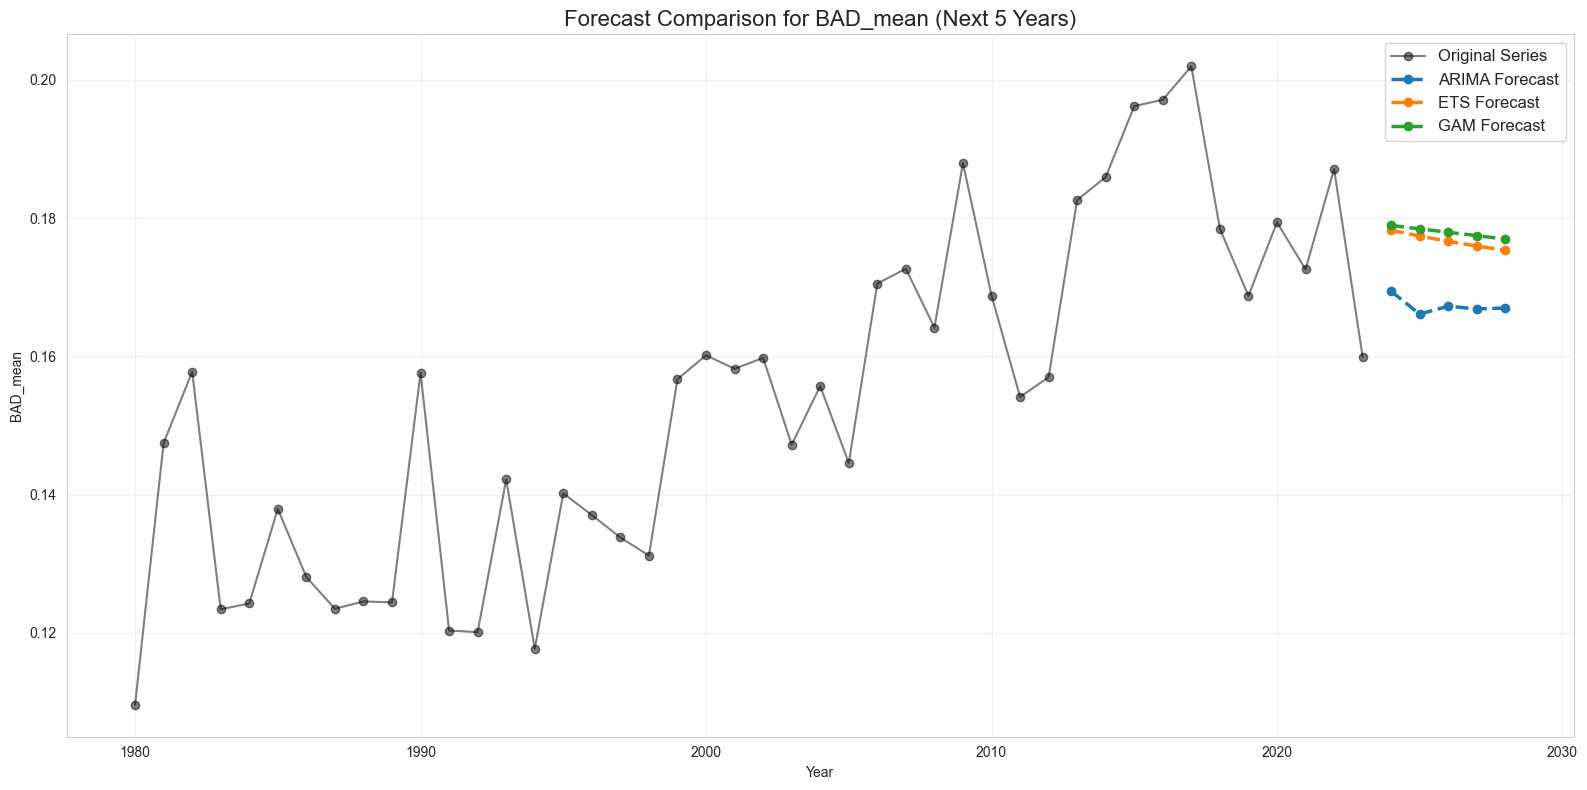

In [43]:
# ============================================================
# Forecast Comparison: ARIMA vs ETS vs GAM
# ============================================================

# ------------------------------------------------------------
# 1. Create a 5-year future year sequence
# ------------------------------------------------------------
last_year = ABT['year'].iloc[-1]
future_years = np.arange(last_year + 1, last_year + 6)  # next 5 years


# ------------------------------------------------------------
# 2. ARIMA Forecast (using your fitted ARIMA model)
# ------------------------------------------------------------
arima_forecast = fit.forecast(steps=5)  # from your previous ARIMA fit


# ------------------------------------------------------------
# 3. ETS / Holt-Winters Forecast (using your fit_hw model)
# ------------------------------------------------------------
ets_forecast = fit_hw.forecast(5)


# ------------------------------------------------------------
# 4. GAM Forecast
# ------------------------------------------------------------
# Predict GAM values for future years

X = ABT[['year']].values.astype(float)
y = ts.values.astype(float)
gam = LinearGAM(s(0, n_splines=12)).gridsearch(X, y)
future_year_grid = future_years.reshape(-1, 1)
gam_forecast = gam.predict(future_year_grid)


# ============================================================
# Plot Forecast Comparison
# ============================================================

plt.figure(figsize=(16, 8))

# ------------------------------
# Plot original series
# ------------------------------
plt.plot(ABT['year'], ts, 'k-o', alpha=0.5, label='Original Series')

# ------------------------------
# ARIMA Forecast
# ------------------------------
plt.plot(future_years, arima_forecast,
         'o--', linewidth=2.5, label='ARIMA Forecast')

# ------------------------------
# ETS Forecast
# ------------------------------
plt.plot(future_years, ets_forecast,
         'o--', linewidth=2.5, label='ETS Forecast')

# ------------------------------
# GAM Forecast
# ------------------------------
plt.plot(future_years, gam_forecast,
         'o--', linewidth=2.5, label='GAM Forecast')

# ------------------------------
# Formatting
# ------------------------------
plt.title(f"Forecast Comparison for {measure}_mean (Next 5 Years)", fontsize=16)
plt.xlabel("Year")
plt.ylabel(f"{measure}_mean")
plt.grid(alpha=0.3)
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()

In [44]:
!jupyter nbconvert --to html --no-input time_series_univariate.ipynb --output ../../../../output/Notebook_Outputs/time_series/distance_human_activity.html

[NbConvertApp] Converting notebook time_series_univariate.ipynb to html
[NbConvertApp] Writing 1809329 bytes to ..\..\..\..\output\Notebook_Outputs\time_series\buily_area_density.html
